# K-Means Clustering Algorithm
#### Abby Irish
#### CS74, Winter 2025
For this homework you are no longer given a code skeleton. It is up to you to decide how to structure your code. Please note, you are expected to implement everything in jupyter notebook and submit the notebook as your solution.

Clustering:
You are given a training dataset in CSV format (hw4_cluster.csv). The files each contain 40 rows with 2 columns. Column 1 & 2 are the features. There are no labels for this dataset. Your goal for this assignment is to implement a clustering algorithm and run it on this dataset. For this assignment you can the Euclidean distance as the distance function. 

In [166]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats

In [192]:
# load in data and convert to array
df = pd.read_csv('/Users/abigailirish/Desktop/CS74/hw4_cluster.csv')
df.head()
data = df[['x1', 'x2']].values

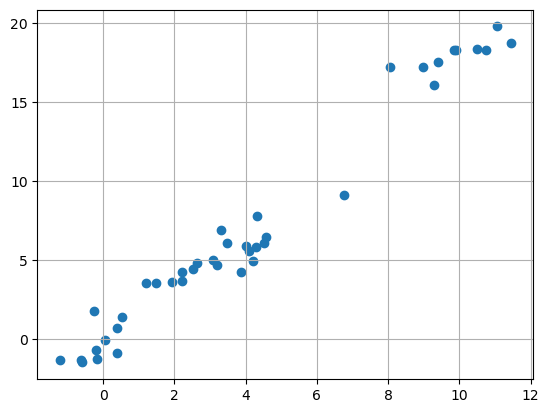

In [168]:
# visualize data
plt.scatter(data[:,0], data[:,1])
plt.grid()
plt.show()

### **K-Means Clustering**
#### Distance Function

In [169]:
# function to return Euclidean distance between two points
def euclidean(p1, p2):
    return np.linalg.norm(p1 - p2)

#### Centroid Functions

In [170]:
# Different ways to "average" for the cetroid of a cluster: mean and median
def mean_centroid(points): 
    if not points.any(): # hanlde case of empty list
        return None
    
    coordinates = np.array(points)
    return np.mean(coordinates, axis=0)

def median_centroid(points):
        if not points.any(): # hanlde case of empty list
            return None
            
        coordinates = np.array(points)
        return np.median(coordinates, axis=0)

#### K-Means Algorithm 
note the parameter to change initialization methods

In [172]:
# Function to implement K-Means clustering
def k_means(data, k, centroid_function, max_iters=100, tolerance=1e-4, init_method="random_seed"):
    clusters = np.zeros(len(data), dtype=int)  # Cluster assignments
    centroids = np.zeros((k, data.shape[1]))  # Centroids
    
    # Initialization Based on init_method
    if init_method == "random_seed":
        # Select `k` random data points as initial centroids
        initial_indices = np.random.choice(len(data), k, replace=False)
        centroids = data[initial_indices]
    
    elif init_method == "random_split":
        # Randomly split data into `k` clusters and compute initial centroids
        split_indices = np.random.randint(0, k, len(data))  # Assign random clusters
        for i in range(k):
            centroids[i] = centroid_function(data[split_indices == i]) if np.any(split_indices == i) else data[np.random.randint(len(data))]
    
    elif init_method == "kmeans++":
        # Smart initialization to spread out initial centroids
        centroids[0] = data[np.random.randint(len(data))]  # First centroid is random
        for i in range(1, k):
            distances = np.array([min([np.linalg.norm(x - c) for c in centroids[:i]]) for x in data])
            probabilities = distances / distances.sum()
            centroids[i] = data[np.random.choice(len(data), p=probabilities)]
    
    else:
        raise ValueError("Invalid init_method. Choose from ['random_seed', 'random_split', 'kmeans++']")
    
    # Clustering Iterations
    for iteration in range(max_iters):
        new_clusters = np.zeros(len(data), dtype=int)
        
        # Assign each point to the nearest centroid
        for i, point in enumerate(data):
            distances = np.array([np.linalg.norm(point - centroid) for centroid in centroids])
            new_clusters[i] = np.argmin(distances)

        # Check for convergence
        if np.array_equal(new_clusters, clusters):
            break

        clusters = new_clusters  # Update clusters

        # Recompute the centroid of each cluster
        for i in range(k):
            if np.any(clusters == i):  # Avoid empty clusters
                centroids[i] = centroid_function(data[clusters == i])

    return clusters, centroids

#### Function to visualize the clusters

In [171]:
# Function to visualize clustering
def visualize_clusters(data, clusters, centroids, average_type, k):
    plt.figure(figsize=(8, 6))
    for cluster in range(k):
        cluster_points = data[clusters == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')

    # Plot centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], s=50, c='black', marker='x', label='Centroids')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(f'K-{average_type} Clustering (k={k})')
    plt.legend()
    plt.show()

### **Model Evaluation**
#### SSE

In [208]:
# function to evaluate SSE
def SSE(centroid_function, data, clusters, centroids):
    sse = 0.0
    for i, centroid in enumerate(centroids):
        cluster_points = data[clusters == i]  
        if len(cluster_points) > 0:
            sse += sum(euclidean(point, centroid) ** 2 for point in cluster_points)
    return sse

for k in range (2, 11):
    clusters, centroids = k_means(data, k, mean_centroid, init_method="random_seed")
    sse_score = SSE(mean_centroid, data, clusters, centroids)
    print(f"SSE (k={k}) = {sse_score}")

SSE (k=2) = 405.61841507712245
SSE (k=3) = 108.31913679127405
SSE (k=4) = 97.02543086472048
SSE (k=5) = 52.82629642175484
SSE (k=6) = 45.1392917730058
SSE (k=7) = 33.34243671737348
SSE (k=8) = 31.63763523002747
SSE (k=9) = 40.84031118458352
SSE (k=10) = 26.66513107418844


A model with k=9 yields the lowest SSE score of about 26.7. This makes sense because more clusters mean data points are closer to their centroids, reducing errors. However, if k is too large, clusters can become too small and less meaningful. Thus, silouette score is a better measure of "goodness" based on both separation and compactness of clusters.

#### Silouette Score

In [207]:
# Function to evaluate silhouette score
def silhouette(points, clusters, centroids):
    n = len(points)
    silhouette_scores = np.zeros(n)

    for i, point in enumerate(points):
        cluster_idx = clusters[i]
        same_cluster = points[clusters == cluster_idx]  # Points in the same cluster

        # Compute a(x): Average intra-cluster distance
        if len(same_cluster) > 1:  
            a_x = np.mean([euclidean(point, p) for p in same_cluster if not np.array_equal(p, point)])
        else:
            a_x = 0  # If the cluster has only one point, intra-cluster distance is 0

        # Compute b(x): Mean distance to the nearest other cluster
        other_clusters = [c for c in range(len(centroids)) if c != cluster_idx]
        min_b_x = float('inf')

        for other_cluster_idx in other_clusters:
            other_cluster_points = points[clusters == other_cluster_idx]
            if len(other_cluster_points) > 0:
                b_x = np.mean([euclidean(point, p) for p in other_cluster_points])
                min_b_x = min(min_b_x, b_x)  # Find the closest cluster

        # Compute silhouette score for the point
        silhouette_scores[i] = (min_b_x - a_x) / max(a_x, min_b_x) if max(a_x, min_b_x) > 0 else 0

    return silhouette_scores

cluster_results = {}
centroid_results = {}

for k in range (2, 11):
    clusters, centroids = k_means(data, k, mean_centroid, init_method="random_seed")
    silhouette_scores = silhouette(data, clusters, centroids)
        
    avg_score = sum(silhouette_scores) / len(silhouette_scores)
    print(f"silouette score (k={k}) = {avg_score}")

silouette score (k=2) = 0.7688769399766378
silouette score (k=3) = 0.7191510173138325
silouette score (k=4) = 0.6184537414007762
silouette score (k=5) = 0.5414467372506275
silouette score (k=6) = 0.43020954263692596
silouette score (k=7) = 0.5243777986725748
silouette score (k=8) = 0.4550929744496509
silouette score (k=9) = 0.5050519246357832
silouette score (k=10) = 0.46285213536293257


The best silouette score is for k=2, meaning these clusters are more well-separated.

#### Function to choose the best model based on silouette score

In [204]:
def choose_best_model(data, k_values, centroid_function, init_method="random_seed"):
    best_k = None
    best_score = float('-inf')

    cluster_results = {}
    centroid_results = {}

    for k in k_values:
        # Ensure init_method is passed to k_means
        clusters, centroids = k_means(data, k, centroid_function, init_method=init_method)
        cluster_results[k] = clusters
        centroid_results[k] = centroids
    
    for k, clusters in cluster_results.items():
        centroids = centroid_results[k]  # Get corresponding centroids
        silhouette_scores = silhouette(data, clusters, centroids)
        
        avg_score = sum(silhouette_scores) / len(silhouette_scores)

        if avg_score > best_score:
            best_score = avg_score
            best_k = k
    
    return best_k, best_score

Best k: 2 with Silhouette Score: 0.7688769399766378


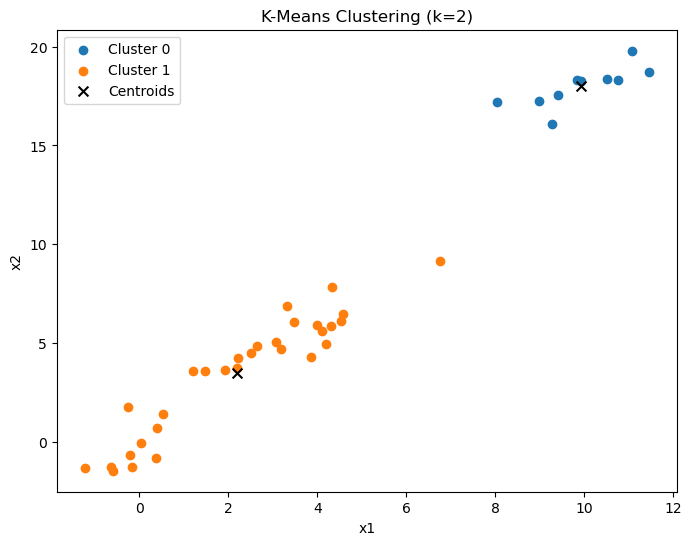

In [188]:
# Find the best K-Means model with random_seed init method
best_k, best_silhouette = choose_best_model(data, range(2, 11), mean_centroid, init_method="random_seed")
print(f"Best k: {best_k} with Silhouette Score: {best_silhouette}")

# Retrieve corresponding best clusters and centroids to plot
best_clusters, best_centroids = k_means(data, best_k, mean_centroid, init_method="random_seed")

# plot the best 
visualize_clusters(data, best_clusters, best_centroids, "Means", best_k)

Best k: 2 with Silhouette Score: 0.7688769399766378


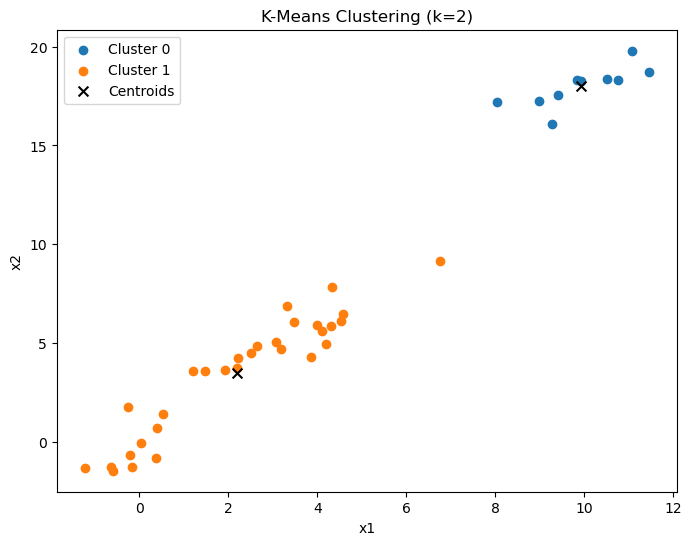

In [189]:
# Find the best K-Means model with kmeans++ init method
best_k, best_silhouette = choose_best_model(data, range(2, 11), mean_centroid, init_method="kmeans++")
print(f"Best k: {best_k} with Silhouette Score: {best_silhouette}")

# Retrieve corresponding best clusters and centroids to plot
best_clusters, best_centroids = k_means(data, best_k, mean_centroid, init_method="kmeans++")

# plot the best 
visualize_clusters(data, best_clusters, best_centroids, "Means", best_k)

Best k: 2 with Silhouette Score: 0.7688769399766378


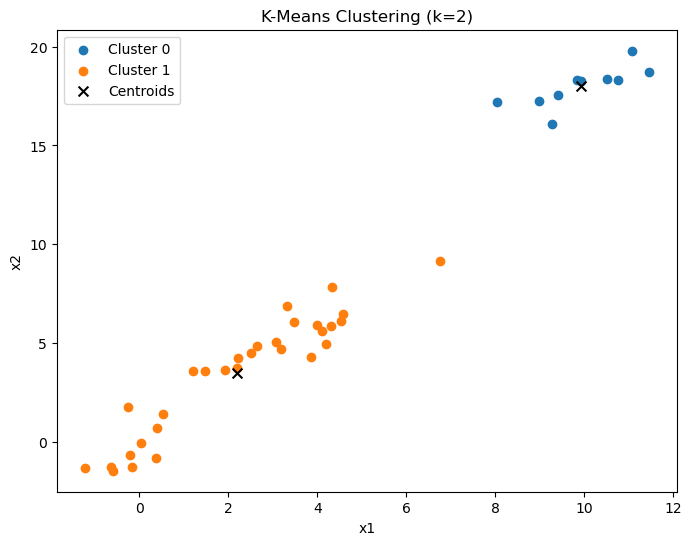

In [184]:
# Find the best K-Means model with random_split init method
best_k, best_silhouette = choose_best_model(data, range(2, 11), mean_centroid, init_method="random_split")
print(f"Best k: {best_k} with Silhouette Score: {best_silhouette}")

# Retrieve corresponding best clusters and centroids to plot
best_clusters, best_centroids = k_means(data, best_k, mean_centroid, init_method="random_split")

# plot the best 
visualize_clusters(data, best_clusters, best_centroids, "Means", best_k)

Best k: 2 with Silhouette Score: 0.7688769399766378


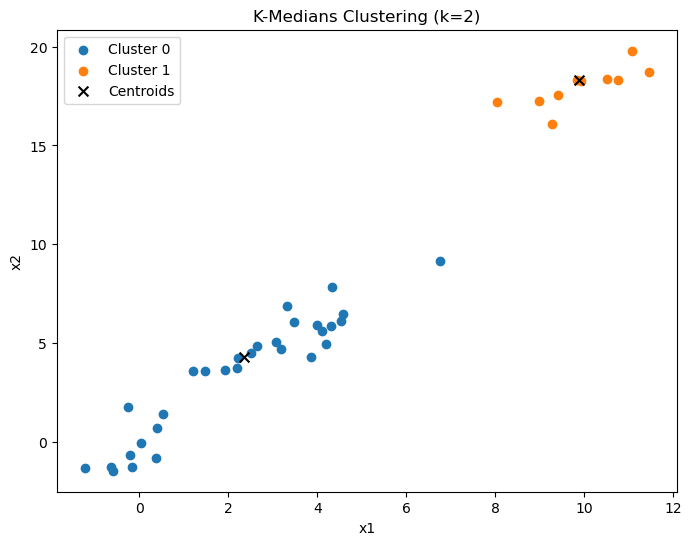

In [185]:
# Find the best K-Medians model
best_k, best_silhouette = choose_best_model(data, range(2, 11), median_centroid)
print(f"Best k: {best_k} with Silhouette Score: {best_silhouette}")

# Retrieve corresponding best clusters and centroids to plot
best_clusters, best_centroids = k_means(data, best_k, median_centroid)

# plot the best 
visualize_clusters(data, best_clusters, best_centroids, "Medians", best_k)

#### Elbow Method

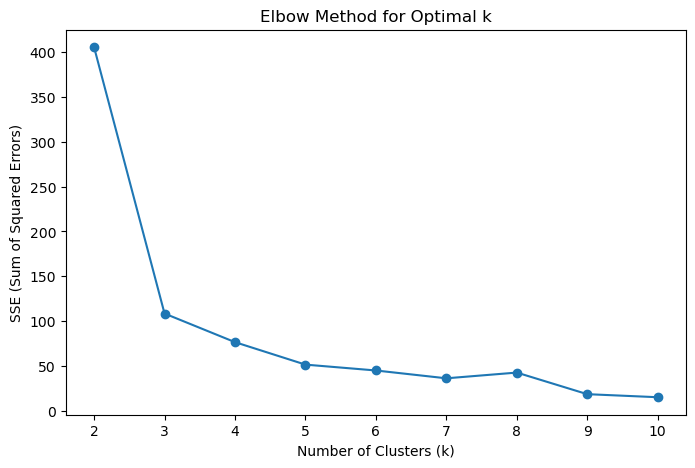

In [210]:
sse_scores = []
k_values = range(2, 11)

for k in k_values:
    clusters, centroids = k_means(data, k, mean_centroid, init_method="random_seed")
    sse_score = SSE(mean_centroid, data, clusters, centroids)
    sse_scores.append(sse_score)

plt.figure(figsize=(8, 5))
plt.plot(k_values, sse_scores, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('Elbow Method for Optimal k')
plt.show()


The optimal k seems to be around k = 3 or k = 4.